# 3. How do availability and stay duration impact listing prices, and what strategies can hosts adopt to optimize their earnings?

## Temporal trends in booking rates and pricing strategies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
import io

# Load calendar data to process
calendar = pd.read_csv('../../data/raw/airbnb/calendar.csv.gz', compression='gzip')

# Given the availability is represented by f: false and t: true, which are not booleans we need to convert them to usable values (0 or 1)
calendar['available'] = calendar['available'].apply(lambda x: 0 if x == 'f' else 1)

# Extract month, year and day from date column in calendar
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['month'] = calendar['date'].dt.month
calendar['year'] = calendar['date'].dt.year
calendar['weekday'] = calendar['date'].dt.weekday

# Convert price column to float
calendar['price'] = calendar['price'].str.replace(',', '').str.lstrip('$')
calendar['price'] = calendar['price'].astype(float)

In [2]:
# Function to remove outliers 
def remove_data_outliers(df, column, threshold=1.5):
    """
    Detect and removel outliers usin InterQuartile Range according to a threshold (defaults to following the 1.5 . IQR rule).
    Called alse Tukey Fences.
    Args:
        df (pandas.DataFrame): Dataframe to remove outliers from
        column (str): Column to remove outliers from

    Returns:
        df_filtered (pandas.DataFrame): Dataframe with outliers removed

    Notes:
    Some references:
    https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_summarizingdata/bs704_summarizingdata7.html
    https://stackoverflow.com/questions/74683825/how-do-i-remove-outliers-from-a-column-in-a-dataframe
    https://www.kaggle.com/code/kenjee/dealing-with-outliers-section-5-2
    """
    # Define the quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Define the interquartile range
    IQR = Q3 - Q1

    # Define the upper and lower bounds for the 1.5 . IQR rule
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # filter out the outliers from df 
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered


Now we compute the monthly booking rate which is an indication of popularity of a listing. Given we already have the availability data, we can extract the booking rate knowing that it is 1 - availability.

In [3]:
# compute the monthly booking rate
booking_monthly_rate = calendar.groupby(['year', 'month'])['available'].apply(lambda x: 1 - x.mean()).reset_index()
# rename the available column to booking rate
booking_monthly_rate.rename(columns={'available': 'booking_rate'}, inplace=True)
booking_monthly_rate



,year,month,booking_rate
0,2022,12,0.546428
1,2023,1,0.405745
2,2023,2,0.346060
3,2023,3,0.397756
4,2023,4,0.395305
5,2023,5,0.379294
6,2023,6,0.480532
7,2023,7,0.492778
8,2023,8,0.489069
9,2023,9,0.513750


In [4]:
# remove prices 0
filtered_calendar = calendar[calendar['price'] != 0]
filtered_calendar = filtered_calendar.groupby(['year', 'month']).apply(remove_data_outliers, 'price').reset_index(drop=True)

filtered_calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,month,year,weekday
0,109,2022-12-07,0,115.0,$115.00,30.0,730.0,12,2022,2
1,109,2022-12-08,0,115.0,$115.00,30.0,730.0,12,2022,3
2,109,2022-12-09,0,115.0,$115.00,30.0,730.0,12,2022,4
3,109,2022-12-10,0,115.0,$115.00,30.0,730.0,12,2022,5
4,109,2022-12-11,0,115.0,$115.00,30.0,730.0,12,2022,6
...,...,...,...,...,...,...,...,...,...,...
13324694,775316807460359720,2023-12-02,0,500.0,$500.00,7.0,365.0,12,2023,5
13324695,775316807460359720,2023-12-03,0,500.0,$500.00,7.0,365.0,12,2023,6
13324696,775316807460359720,2023-12-04,0,500.0,$500.00,7.0,365.0,12,2023,0
13324697,775316807460359720,2023-12-05,0,500.0,$500.00,7.0,365.0,12,2023,1


In [5]:
# Compute the filtered monthly average price per month

monthly_avg_price = filtered_calendar.groupby(['year', 'month'])['price'].mean().reset_index()
monthly_avg_price

,year,month,price
0,2022,12,155.005255
1,2023,1,163.891522
2,2023,2,165.703327
3,2023,3,164.839070
4,2023,4,167.399223
5,2023,5,169.680753
6,2023,6,171.876937
7,2023,7,172.410037
8,2023,8,171.753666
9,2023,9,170.955468


In [6]:
listings_offering = filtered_calendar.groupby(['year', 'month'])['listing_id'].nunique().reset_index()
listings_offering

,year,month,listing_id
0,2022,12,36892
1,2023,1,36993
2,2023,2,36941
3,2023,3,36787
4,2023,4,36777
5,2023,5,36900
6,2023,6,36780
7,2023,7,36683
8,2023,8,36747
9,2023,9,36827


In [7]:
filtered_calendar.groupby(['year', 'month'])['price'].describe()

count        mean         std   min   25%    50%    75%    max
year month                                                                    
2022 12      910486.0  155.005255   98.829878  10.0  80.0  129.0  200.0  493.0
2023 1      1134341.0  163.891522  107.162512  10.0  85.0  135.0  215.0  514.0
     2      1024510.0  165.703327  109.397118  10.0  85.0  136.0  219.0  529.0
     3      1132190.0  164.839070  109.336163  10.0  85.0  135.0  217.0  529.0
     4      1094943.0  167.399223  110.726830  10.0  85.0  139.0  220.0  540.0
     5      1135014.0  169.680753  113.770530  10.0  86.0  139.0  224.0  550.0
     6      1094862.0  171.876937  115.453000  10.0  88.0  140.0  225.0  562.0
     7      1127879.0  172.410037  116.578092  10.0  88.0  140.0  225.0  570.0
     8      1129675.0  171.753666  115.564587  10.0  88.0  140.0  225.0  562.0
     9      1097098.0  170.955468  114.032940  10.0  88.0  140.0  225.0  552.0
     10     1135480.0  170.410898  113.564894  10.0  88.0  140.0  224.0  550.0
     11     1095352.0  168.901637  110.870534  10.0  88.0  140.0  221.0  542.0
     12      212869.0  168.574593  110.434831  10.0  89.0  139.0  220.0  540.0

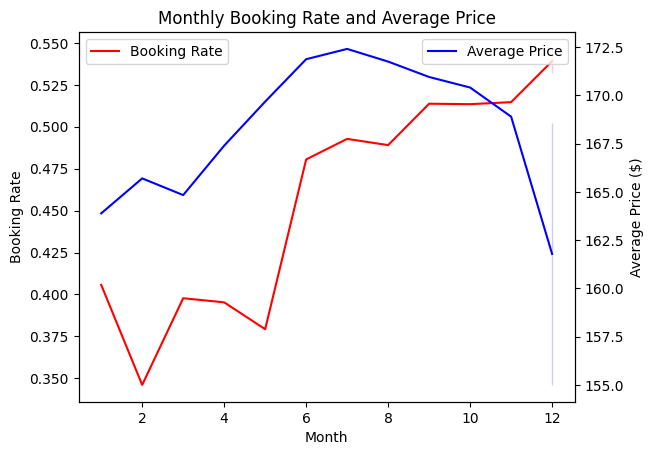

In [8]:
fig, ax1 = plt.subplots()

# Plot monthly booking rate
sns.lineplot(data=booking_monthly_rate, x='month', y='booking_rate', color='red', ax=ax1, label='Booking Rate')
ax1.set_xlabel('Month')
ax1.set_ylabel('Booking Rate')
ax1.set_title('Monthly Booking Rate and Average Price')

# Plot monthly average price 
ax2 = ax1.twinx()
sns.lineplot(data=monthly_avg_price, x='month', y='price', color='blue', ax=ax2, label='Average Price')
ax2.set_ylabel('Average Price ($)')

# Save the plots to a png file
plt.savefig('../../reports/figures/question_3/monthly_booking_rate_and_average_price.png', bbox_inches='tight')

plt.show()


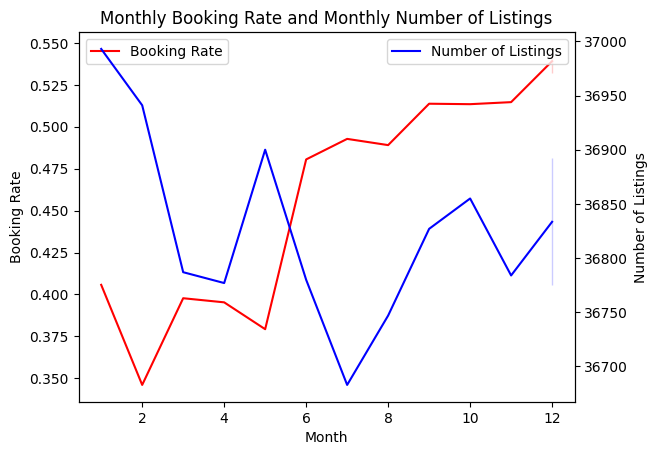

In [9]:
fig, ax1 = plt.subplots()

# Plot monthly booking rate
sns.lineplot(data=booking_monthly_rate, x='month', y='booking_rate', color='red', ax=ax1, label='Booking Rate')
ax1.set_xlabel('Month')
ax1.set_ylabel('Booking Rate')
ax1.set_title('Monthly Booking Rate and Monthly Number of Listings')

# Plot monthly average price 
ax2 = ax1.twinx()
sns.lineplot(data=listings_offering, x='month', y='listing_id', color='blue', ax=ax2, label='Number of Listings')
ax2.set_ylabel('Number of Listings')

# Save the plots to a png file
plt.savefig('../../reports/figures/question_3/monthly_booking_rate_and_monthly_number_of_listings.png', bbox_inches='tight')

plt.show()


In [10]:
booking_monthly_rate

,year,month,booking_rate
0,2022,12,0.546428
1,2023,1,0.405745
2,2023,2,0.346060
3,2023,3,0.397756
4,2023,4,0.395305
5,2023,5,0.379294
6,2023,6,0.480532
7,2023,7,0.492778
8,2023,8,0.489069
9,2023,9,0.513750


In [11]:
monthly_avg_price

,year,month,price
0,2022,12,155.005255
1,2023,1,163.891522
2,2023,2,165.703327
3,2023,3,164.839070
4,2023,4,167.399223
5,2023,5,169.680753
6,2023,6,171.876937
7,2023,7,172.410037
8,2023,8,171.753666
9,2023,9,170.955468


In [12]:
# create new dataframe with monthly_avg_price and booking_monthly_rate
seasonality_df = monthly_avg_price
seasonality_df = seasonality_df.merge(booking_monthly_rate, how='left', on=['month', 'year'])
seasonality_df

,year,month,price,booking_rate
0,2022,12,155.005255,0.546428
1,2023,1,163.891522,0.405745
2,2023,2,165.703327,0.346060
3,2023,3,164.839070,0.397756
4,2023,4,167.399223,0.395305
5,2023,5,169.680753,0.379294
6,2023,6,171.876937,0.480532
7,2023,7,172.410037,0.492778
8,2023,8,171.753666,0.489069
9,2023,9,170.955468,0.513750


In [13]:
# compute correlation between two columns in pandas dataframe
correlation = seasonality_df['price'].corr(seasonality_df['booking_rate'])    
correlation

0.04684208633917481

In [14]:
# Compute average price for a day in a week.
weekday_avg_price = filtered_calendar.groupby('weekday')['price'].mean().reset_index()
# add column names
weekday_avg_price.name = 'Average Price'
# replace index with weekday names
weekday_avg_price.weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_avg_price

,weekday,price
0,Monday,166.824098
1,Tuesday,166.709506
2,Wednesday,166.576078
3,Thursday,167.076633
4,Friday,170.441077
5,Saturday,170.622862
6,Sunday,167.508425


In [15]:
import plotly.express as px
import plotly.io as pio

save_dir = '../../reports/figures/question_3/'

# Bar plot of average price per weekday
fig = px.bar(
    weekday_avg_price,
    x="weekday",
    y="price",
    title="Average price for each Day of the Week",
    labels={
        "weekday": "Day of the Week",
        "price": "Price ($)",
    },
)
fig.update_layout(title_x = 0.5, width=700)
fig.write_image(f'{save_dir}average_price_weekday.png')
fig.show()
    


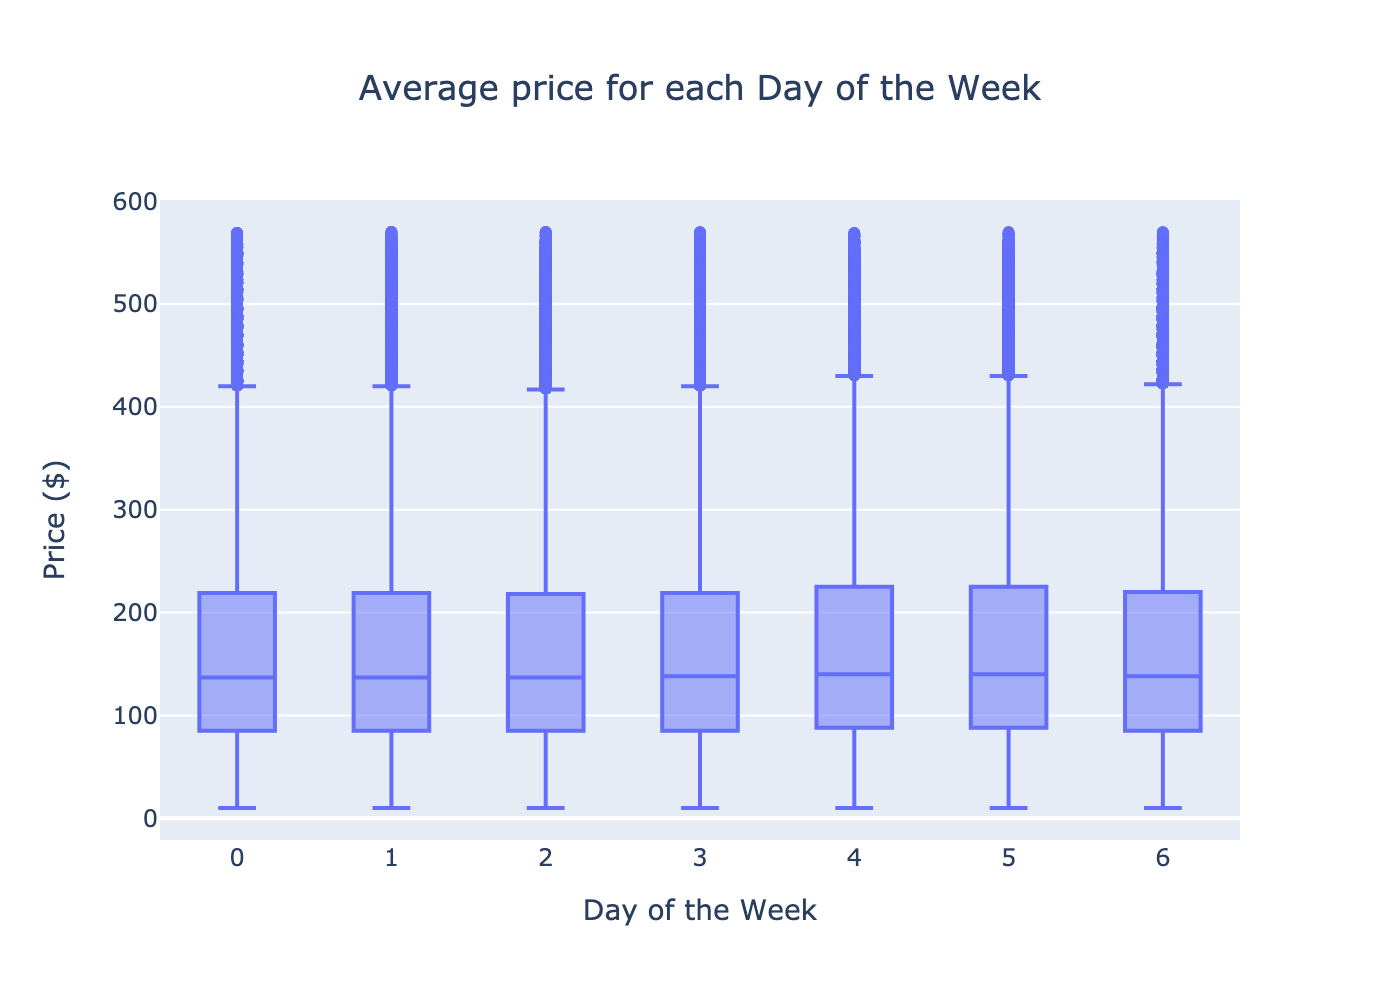

In [18]:
import plotly.express as px
import plotly.io as pio
from PIL import Image
from IPython.display import display

save_dir = '../../reports/figures/question_3/'

sampled_filtered_calendar = filtered_calendar.groupby('weekday').apply(lambda x: x.sample(frac=0.1, random_state=42))
# Bar plot of average price per weekday
fig = px.box(
    sampled_filtered_calendar,
    x="weekday",
    y="price",
    title="Average price for each Day of the Week",
    labels={
        "weekday": "Day of the Week",
        "price": "Price ($)",
    },
)
fig.update_layout(title_x = 0.5, width=700)
image_path = f'{save_dir}boxplot_average_price_weekday.png'
fig.write_image(image_path,scale=2)
# show image 
img = Image.open(image_path)
display(img)

In [19]:
from scipy import stats
# Prepare data for ANOVA test
week_days = [i for i in range(7)]
weekday_groups = [filtered_calendar.loc[filtered_calendar['weekday'] == day, 'price'] for day in week_days]

# Perform one-way ANOVA test (ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html)
f_val, p_val = stats.f_oneway(*weekday_groups)
print(f"One-way ANOVA F-value: {f_val}")
print(f"One-way ANOVA p-value: {p_val}")

One-way ANOVA F-value: 481.08981323865015
One-way ANOVA p-value: 0.0


In [20]:
filtered_calendar.groupby('weekday')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
0,1906373.0,166.824098,110.885948,10.0,85.0,138.0,219.0,570.0
1,1913426.0,166.709506,110.825183,10.0,85.0,138.0,219.0,570.0
2,1935668.0,166.576078,110.659270,10.0,85.0,138.0,219.0,570.0
3,1902339.0,167.076633,111.059682,10.0,85.0,138.0,220.0,570.0
4,1883194.0,170.441077,113.220102,10.0,88.0,140.0,225.0,570.0
5,1882171.0,170.622862,113.367078,10.0,88.0,140.0,225.0,570.0
6,1901528.0,167.508425,111.408010,10.0,85.0,139.0,220.0,570.0


## Impact of stay duration on listing prices

/var/folders/kk/3n5ft7ts6fjgmmp11zwz_ybh0000gn/T/ipykernel_30884/2369978462.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Average Price By Stay Duration (stay_duration_bins
1        158.457717
2-3      216.556170
4-7      204.774440
8-14     175.778633
15-30    147.681666
30+      147.801556
Name: price, dtype: float64):
                        count        mean         std   min    25%    50%   
stay_duration_bins                                                          
1                   2455609.0  158.457717  107.859118  10.0   75.0  137.0  \
2-3                 2812632.0  216.556170  123.791784  10.0  120.0  191.0   
4-7                  802913.0  204.774440  131.011093  10.0   95.0  176.0   
8-14                 137717.0  175.778633  121.719213  22.0   71.0  148.0   
15-30               5276909.0  147.681666  100.537936  10.0   80.0  115.0   
30+                 1838910.0  147.801556   88.394747  10.0   85.0  130.0   

                      75%    max  
stay_duration_bins                
1                   201.0  570.0  
2-3                 297.0  570.0  
4-7                 292.0  570.0  
8-14   

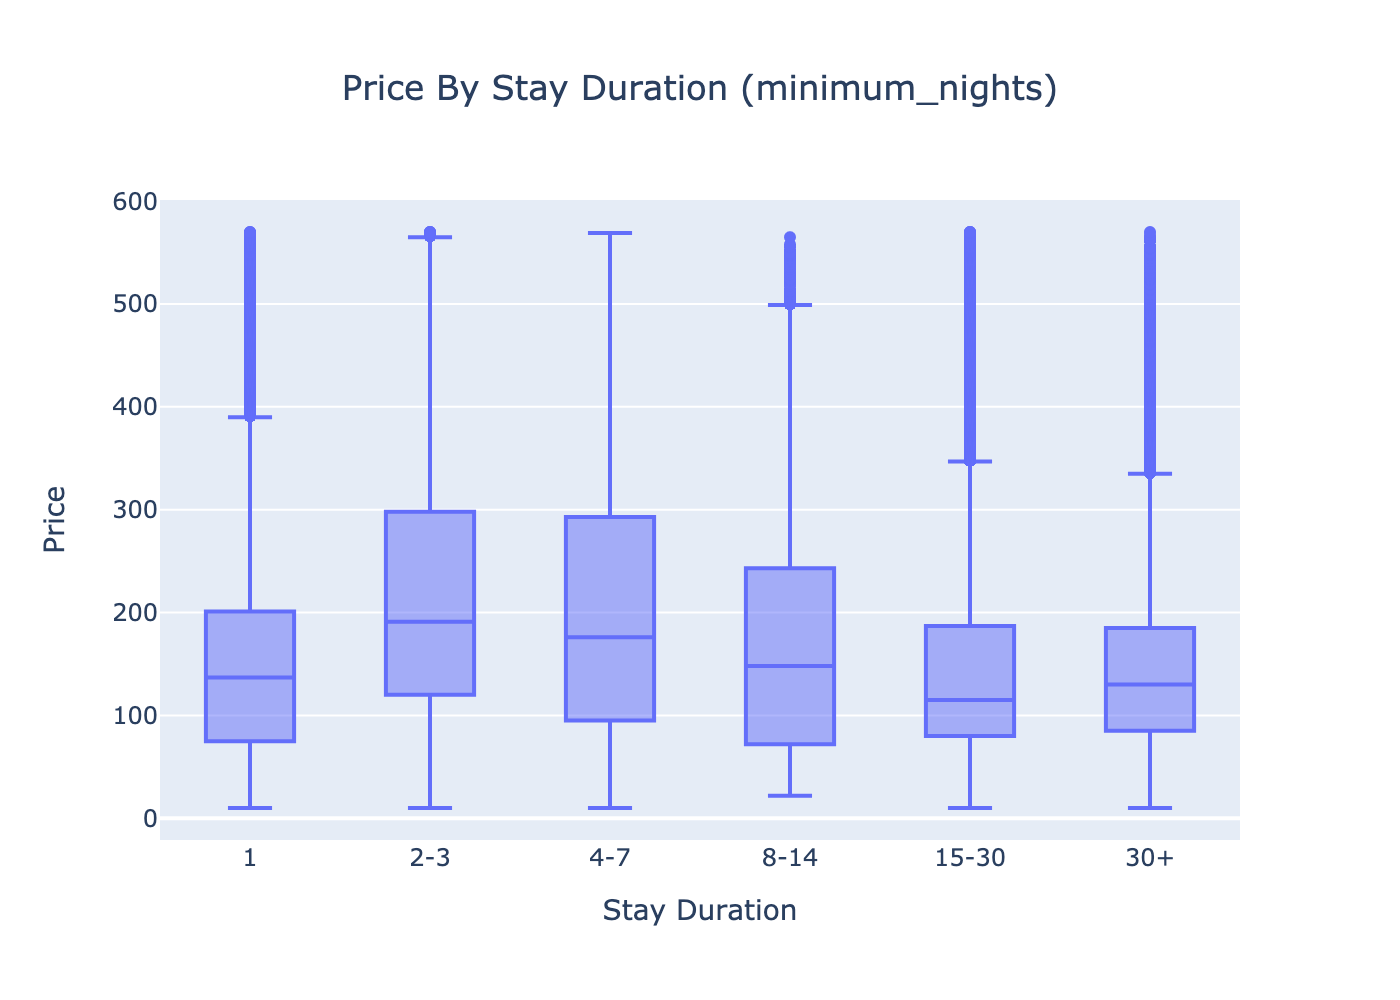

One-way ANOVA F-value: 186785.18033824165
One-way ANOVA p-value: 0.0


In [21]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def avg_price_vs_stay_duration(calendar, col_name, save_path):
    """
    Create Bar plot for Average Price vs Stay duration and perform one-way ANOVA test.

    Args:
        col_name (str): Name of the column (stay duration)
        save_path (str): Path to save the generated plot

    Returns:
        None
    """

    # Create stay duration bins
    stay_duration_bins = pd.cut(calendar[col_name], bins=[0, 1, 3, 7, 14, 30, np.inf], labels=['1', '2-3', '4-7', '8-14', '15-30', '30+'])

    # Create a dataframe with price and stay duration
    calendar_clean = calendar.dropna(subset=[col_name, 'price'])
    calendar_clean['stay_duration_bins'] = stay_duration_bins

    # sample calendar_clean (proportional)
    sample_calendar_clean = calendar_clean.groupby('stay_duration_bins').apply(lambda x: x.sample(frac=0.1))

    # Calculate average price based on stay duration
    stay_duration_avg_price = calendar_clean.groupby('stay_duration_bins')['price'].mean()

    print(f"Average Price By Stay Duration ({stay_duration_avg_price}):")
    print(calendar_clean.groupby('stay_duration_bins')['price'].describe())

    # Box plot Price vs Stay duration
    fig = px.box(
        sample_calendar_clean,
        x='stay_duration_bins',
        y='price',
        title=f'Price By Stay Duration ({col_name})',
        labels={'price': 'Price', 'stay_duration_bins': 'Stay Duration'},

    )
    fig.update_layout(title_x=0.5, width=700)
    image_path = f'{save_path}/avg_price_vs_stay_duration_{col_name}.png'
    fig.write_image(image_path, scale=2)
    # show image 
    img = Image.open(image_path)
    display(img)


    # Prepare data for ANOVA test
    stay_duration_groups = [calendar_clean.loc[calendar_clean['stay_duration_bins'] == bin, 'price'] for bin in stay_duration_bins.cat.categories]

    # Perform one-way ANOVA test
    f_val, p_val = stats.f_oneway(*stay_duration_groups)
    print(f"One-way ANOVA F-value: {f_val}")
    print(f"One-way ANOVA p-value: {p_val}")
    

dir_path='../../reports/figures/question_3/'
avg_price_vs_stay_duration(filtered_calendar, 'minimum_nights', dir_path)



/var/folders/kk/3n5ft7ts6fjgmmp11zwz_ybh0000gn/T/ipykernel_30884/2369978462.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Average Price By Stay Duration (stay_duration_bins
1        235.130893
2-3      129.929561
4-7      141.895136
8-14     163.508967
15-30    185.064497
30+      167.131377
Name: price, dtype: float64):
                         count        mean         std   min    25%    50%   
stay_duration_bins                                                           
1                      12155.0  235.130893  151.019951  28.0  100.0  200.0  \
2-3                    39708.0  129.929561   84.385124  17.0   75.0   99.0   
4-7                   147305.0  141.895136  100.634015  17.0   74.0  115.0   
8-14                  172864.0  163.508967  106.723549  10.0   80.0  134.0   
15-30                 889067.0  185.064497  122.738452  17.0   89.0  150.0   
30+                 12063591.0  167.131377  110.828763  10.0   86.0  138.0   

                      75%    max  
stay_duration_bins                
1                   299.0  529.0  
2-3                 179.0  529.0  
4-7                 175.0  562.0  

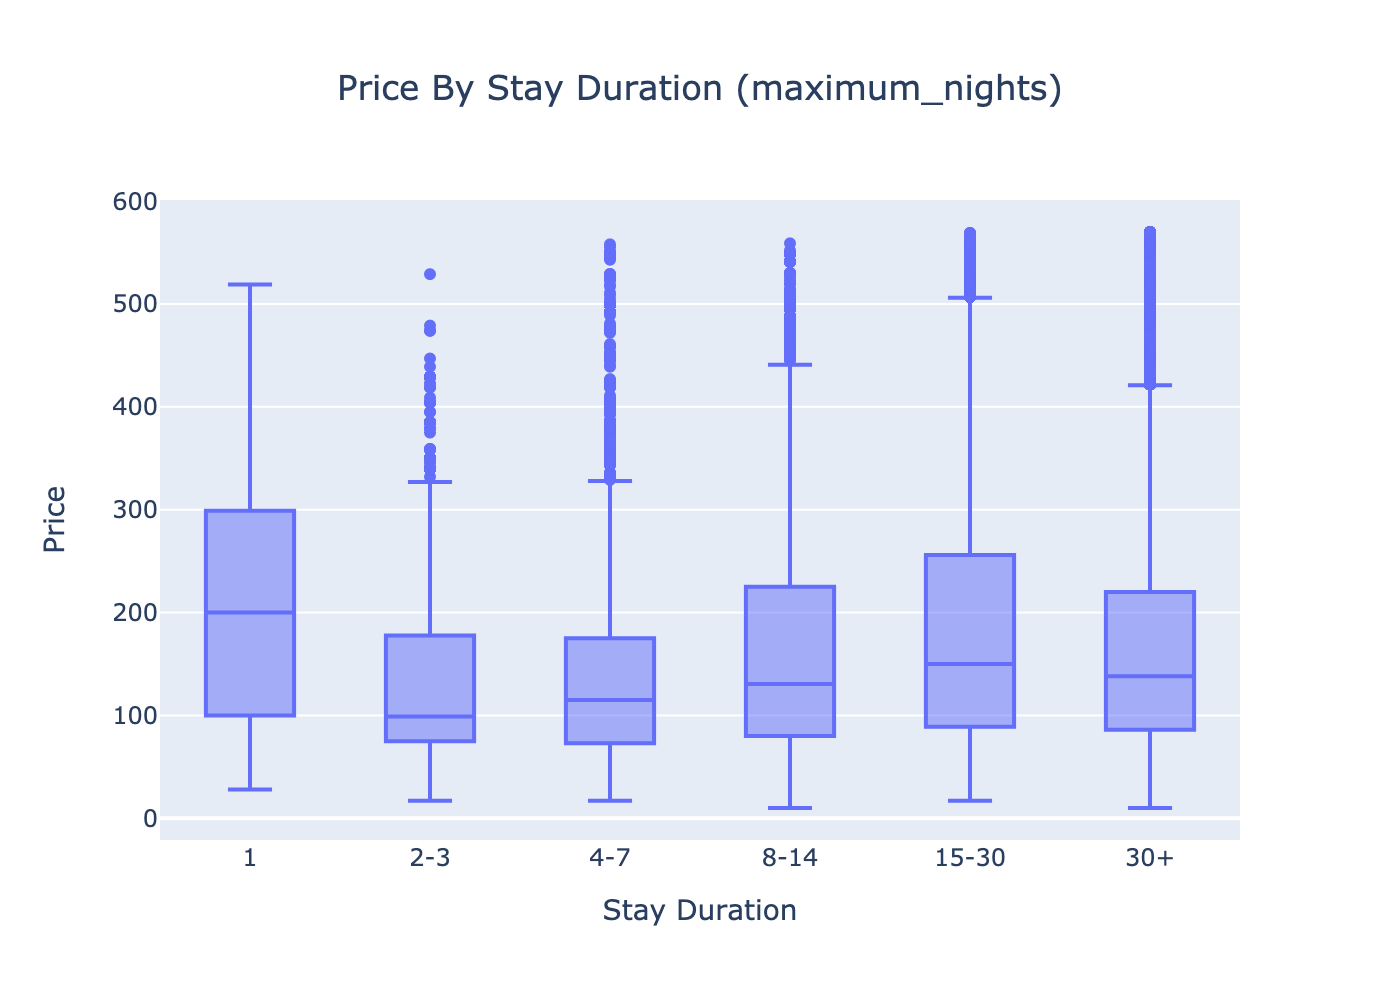

One-way ANOVA F-value: 7791.874572710098
One-way ANOVA p-value: 0.0


In [22]:
avg_price_vs_stay_duration(filtered_calendar, 'maximum_nights', save_dir)

## Impact of availability on listing prices

We try to analyse the relationship between availability and listing price.
To simplify our work we segment our listings into 3 availability categories (low, medium, high) using percentiles.

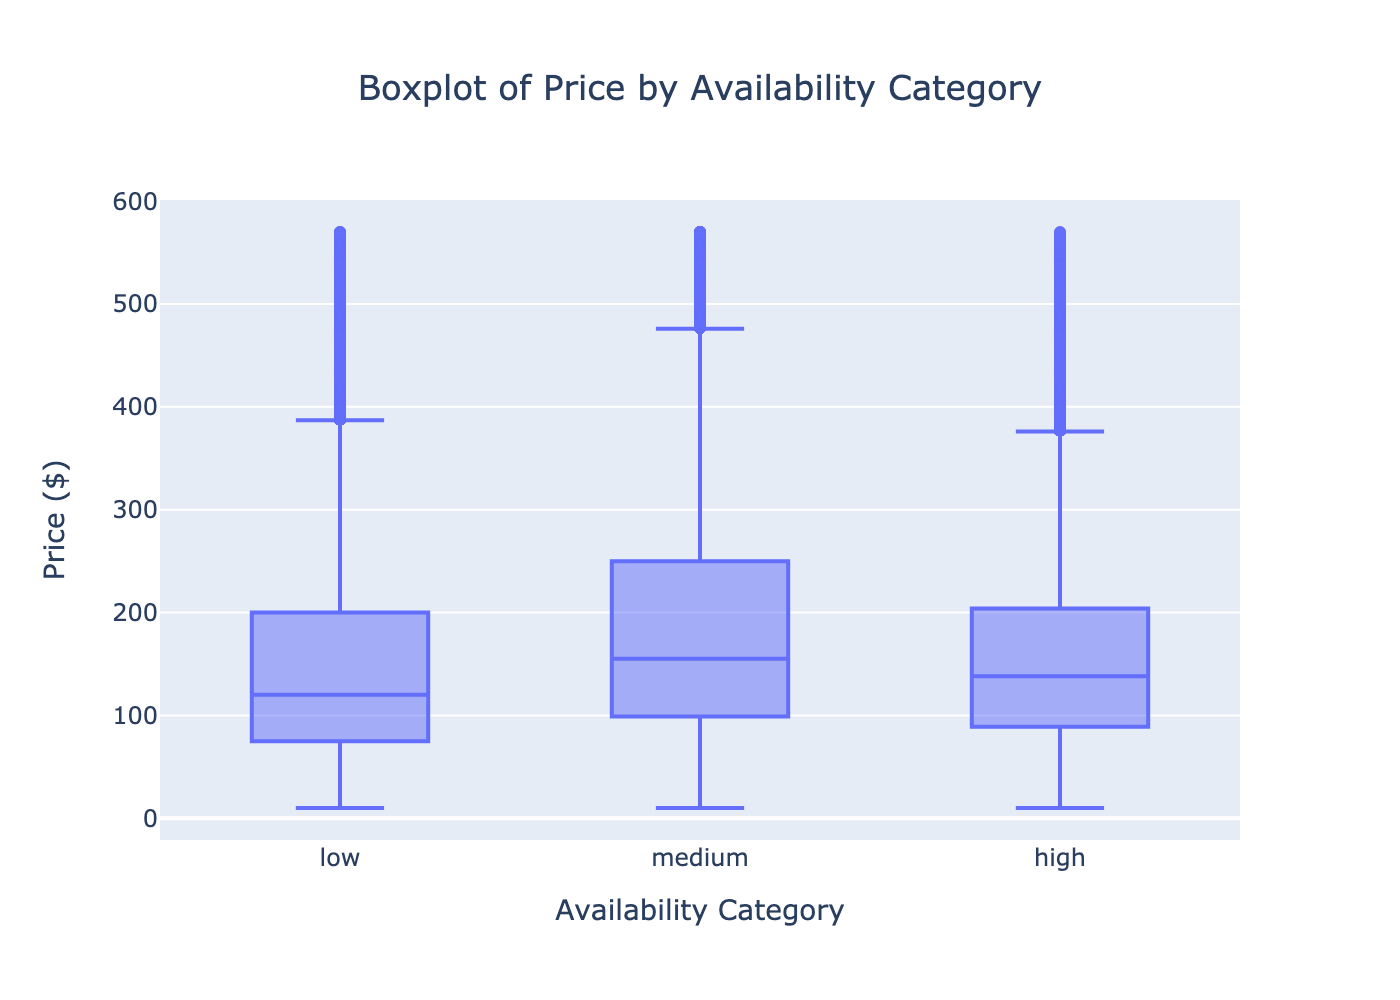

In [23]:
# drop rows with missing values in the 'price' column
calendar_avail = filtered_calendar.dropna(subset=['price'])

# Calculate the number of available days for each listing
availability_count = calendar_avail.groupby('listing_id')['available'].sum().rename('num_available_days')
calendar_avail = calendar_avail.merge(availability_count, on='listing_id')

# Group the number of available days into 3 categories based on the data distribution
quantiles = [0, .33, .66, 1.]
categories = ['low', 'medium', 'high']
calendar_avail['availability_category'] = pd.qcut(calendar_avail['num_available_days'], q=quantiles, labels=categories)

# sample calendendar_avail propertionally to availability category
sample_calendar_avail = calendar_avail.groupby('availability_category').apply(lambda x: x.sample(frac=0.1, random_state=42))

# Calculate the average price for each availability category
avg_price_by_availability = calendar_avail.groupby('availability_category')['price'].mean().reset_index()

# Box Plot price vs availability category
fig = px.box(
    sample_calendar_avail,
    x='availability_category',
    y='price',
    title='Boxplot of Price by Availability Category',
    labels={
        'availability_category': 'Availability Category',
        'price': 'Price ($)'
    }
)
fig.update_layout(title_x=0.5, width=700)
image_path = f'{dir_path}/boxplot_price_availability_category.png'
fig.write_image(image_path,scale=2)
# show image 
img = Image.open(image_path)
display(img)

In [24]:
availability_count.describe()

count    37529.000000
mean       189.008020
std        142.512962
min          0.000000
25%         49.000000
50%        179.000000
75%        341.000000
max        366.000000
Name: num_available_days, dtype: float64

In [25]:
calendar_avail

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,month,year,weekday,num_available_days,availability_category
0,109,2022-12-07,0,115.0,$115.00,30.0,730.0,12,2022,2,227,medium
1,109,2022-12-08,0,115.0,$115.00,30.0,730.0,12,2022,3,227,medium
2,109,2022-12-09,0,115.0,$115.00,30.0,730.0,12,2022,4,227,medium
3,109,2022-12-10,0,115.0,$115.00,30.0,730.0,12,2022,5,227,medium
4,109,2022-12-11,0,115.0,$115.00,30.0,730.0,12,2022,6,227,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
13324694,49796933,2023-12-03,1,215.0,$215.00,30.0,1125.0,12,2023,6,4,low
13324695,49796933,2023-12-04,1,215.0,$215.00,30.0,1125.0,12,2023,0,4,low
13324696,49796933,2023-12-05,1,215.0,$215.00,30.0,1125.0,12,2023,1,4,low
13324697,49796933,2023-12-06,1,215.0,$215.00,30.0,1125.0,12,2023,2,4,low


In [26]:
avg_price_by_availability

,availability_category,price
0,low,155.330206
1,medium,187.923673
2,high,160.944787


In [27]:
calendar_avail.groupby('availability_category')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
availability_category,,,,,,,,
low,4424247.0,155.330206,111.656905,10.0,75.0,120.0,200.0,570.0
medium,4382096.0,187.923673,118.150786,10.0,99.0,155.0,250.0,570.0
high,4518356.0,160.944787,102.066783,10.0,89.0,138.0,203.0,570.0


In [28]:
# Perform one-way ANOVA statistical test to check if the mean of the three groups differs significantly.
Low_avail = calendar_avail[calendar_avail['availability_category']=='low']['price']
Mid_avail = calendar_avail[calendar_avail['availability_category']=='medium']['price']
High_avail = calendar_avail[calendar_avail['availability_category']=='high']['price']
f_stat, p_value = stats.f_oneway(Low_avail, Mid_avail, High_avail)
print('F-statistic: ', f_stat)
print('p-value: ', p_value)

F-statistic:  109049.65606328653
p-value:  0.0


## Joint effect of availability and stay duration on listing price

/var/folders/kk/3n5ft7ts6fjgmmp11zwz_ybh0000gn/T/ipykernel_30884/1005379951.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



availability_category         low      medium        high
min_nights_bin                                           
1                      306.013709  294.715167  280.811896
2-3                    306.241380  365.091059  529.846124
4-7                    343.686500  526.660286  769.761427
8-14                   293.493657  323.538552  666.092188
15-30                  210.140124  233.241461  330.381149
30+                    224.516609  180.845349  229.439123


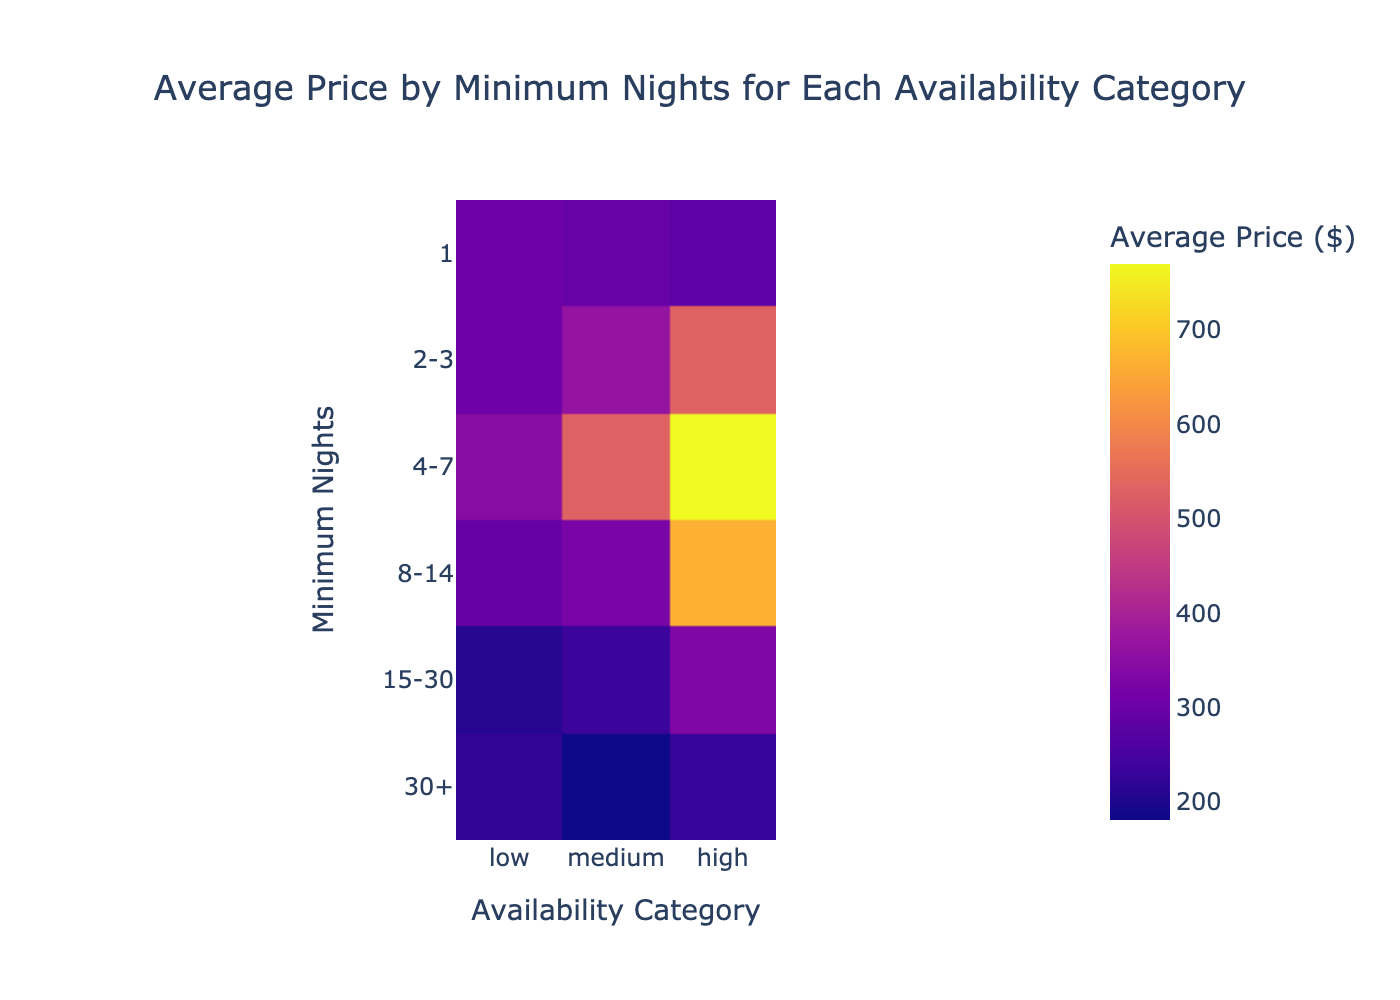

In [29]:
import seaborn as sns
import numpy as np

calendar_avail = calendar.dropna(subset=['price'])

# Create stay duration bins for minimum_nights and maximum_nights
calendar_avail['min_nights_bin'] = pd.cut(calendar_avail['minimum_nights'], bins=[0, 1, 3, 7, 14, 30, np.inf], labels=['1', '2-3', '4-7', '8-14', '15-30', '30+'])

# Calculate the number of available days for each listing
availability_count = calendar_avail.groupby('listing_id')['available'].sum().rename('num_available_days')
calendar_avail = calendar_avail.merge(availability_count, on='listing_id')

# Group the number of available days into 3 categories based on the data distribution
calendar_avail['availability_category'] = pd.qcut(calendar_avail['num_available_days'], q=[0, .33, .66, 1], labels=['low', 'medium', 'high'])

# Calculate the average price for each combination of availability category and stay duration
availability_stay_duration_price = calendar_avail.groupby(['availability_category', 'min_nights_bin'])['price'].mean().reset_index()

# Create a pivot table with average prices for each combination of availability category and stay duration
pivot_table_min = availability_stay_duration_price.pivot_table(index=['min_nights_bin'], columns='availability_category', values='price')
print(pivot_table_min)

# Plot the heatmap
fig = px.imshow(
    pivot_table_min,
    labels=dict(x="Availability Category", y="Minimum Nights", color="Average Price ($)"),
    x=pivot_table_min.columns,
    y=pivot_table_min.index,
    title= 'Average Price by Minimum Nights for Each Availability Category'
)
fig.update_layout(title_x=0.5, width=700)
image_path = f"{save_dir}avg_price_min_nights_availability_category.png"
fig.write_image(image_path,scale=2)
# show image 
img = Image.open(image_path)
display(img)

